<h1>Lab | Clustering songs</h1>

Now it's time to cluster the songs of the **hot_songs** and **not_hot_songs** databases according to the song's audio features. For this purpose, you need to consider the following questions:

- Are you going to use all the audio features? If not, which ones do you think that makes more sense to be used?
- What is the optimal number of clusters (for methods that need to know this beforehand)?
- What is the best distance to use?
- What clustering method provides better results?
- Does the clustering method need a transformer?

**Considerations**

Be aware that this process is extremely time-consuming!!! (it might take several hours in your laptop). Therefore, when testing different options, save the models into your disk in order to be able to use the best model later. You don't want to retrain the best model again when you know what are the optimal parameters for each. To determine which clustering method performs best, you need to be practical and think how many clusters you might want to have alongside with a clustering metric to evaluate how good or bad the songs were clustered. If the number of clusters is small, each cluster will be too big and generic. On the other hand, if the number of clusters is too big then each cluster it will be too specific and it will be poorly populated (this it also depend on how heterogeneous is your dataset).

On the other hand, when you train your clustering model make sure to concatenate both databases together (ie: **hot_songs** and **not_hot_songs**) before. If you don't combine both datasets, the clusters obtained with the **hot_songs** will be different than the ones obtained with the **not_hot_songs** database even though they might have the same label because they will contain different songs. However, after this you will not know to which original dataframe belongs each song. To prevent this problem, you can add a new column named "dataset" with a "flag" to remind yourself in which dataset was included each song.

Finally, add new column to the full dataset **for each clustering method with the cluster membership of each song**

In [1]:
import pandas as pd
from sklearn import datasets 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pickle
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.mixture import GaussianMixture
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import sys
sys.path.insert(1, '/content/drive/MyDrive/Credentials/')
from config import *
import json

**Let's choose audio features that we will use in our models.**

In [2]:
pd.set_option('display.max_columns', None)
final_dataset = pd.read_csv('final_dataset.csv')
final_dataset.head()

,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,s_type
0,anti-hero,taylor swift,0.637,0.643,4.0,-6.571,1.0,0.0519,0.130,0.000002,0.142,0.5330,97.008,audio_features,0V3wPSX9ygBnCm8psDIegu,spotify:track:0V3wPSX9ygBnCm8psDIegu,https://api.spotify.com/v1/tracks/0V3wPSX9ygBn...,https://api.spotify.com/v1/audio-analysis/0V3w...,200690.0,4.0,hot
1,lift me up,rihanna,0.247,0.299,9.0,-6.083,1.0,0.0315,0.899,0.000000,0.131,0.1720,177.115,audio_features,35ovElsgyAtQwYPYnZJECg,spotify:track:35ovElsgyAtQwYPYnZJECg,https://api.spotify.com/v1/tracks/35ovElsgyAtQ...,https://api.spotify.com/v1/audio-analysis/35ov...,196520.0,4.0,hot
2,bad habit,steve lacy,0.686,0.507,1.0,-7.097,1.0,0.0357,0.626,0.000075,0.383,0.6900,168.955,audio_features,5CM4UuQ9Gnd6K2YyKGPMoK,spotify:track:5CM4UuQ9Gnd6K2YyKGPMoK,https://api.spotify.com/v1/tracks/5CM4UuQ9Gnd6...,https://api.spotify.com/v1/audio-analysis/5CM4...,232115.0,4.0,hot
3,as it was,harry styles,0.520,0.731,6.0,-5.338,0.0,0.0557,0.342,0.001010,0.311,0.6620,173.930,audio_features,4LRPiXqCikLlN15c3yImP7,spotify:track:4LRPiXqCikLlN15c3yImP7,https://api.spotify.com/v1/tracks/4LRPiXqCikLl...,https://api.spotify.com/v1/audio-analysis/4LRP...,167303.0,4.0,hot
4,lavender haze,taylor swift,0.733,0.436,10.0,-10.489,1.0,0.0800,0.258,0.000573,0.157,0.0976,96.985,audio_features,5jQI2r1RdgtuT8S3iG8zFC,spotify:track:5jQI2r1RdgtuT8S3iG8zFC,https://api.spotify.com/v1/tracks/5jQI2r1Rdgtu...,https://api.spotify.com/v1/audio-analysis/5jQI...,202396.0,4.0,hot


In [3]:
final_dataset.columns

Index(['track_name', 'artist_name', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature', 's_type'],
      dtype='object')

In [4]:
data = final_dataset[['track_name', 'artist_name', 'type', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'tempo', 'time_signature']]
data.head()

,track_name,artist_name,type,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature
0,anti-hero,taylor swift,audio_features,0.637,0.643,4.0,-6.571,1.0,0.0519,0.130,0.000002,0.142,97.008,4.0
1,lift me up,rihanna,audio_features,0.247,0.299,9.0,-6.083,1.0,0.0315,0.899,0.000000,0.131,177.115,4.0
2,bad habit,steve lacy,audio_features,0.686,0.507,1.0,-7.097,1.0,0.0357,0.626,0.000075,0.383,168.955,4.0
3,as it was,harry styles,audio_features,0.520,0.731,6.0,-5.338,0.0,0.0557,0.342,0.001010,0.311,173.930,4.0
4,lavender haze,taylor swift,audio_features,0.733,0.436,10.0,-10.489,1.0,0.0800,0.258,0.000573,0.157,96.985,4.0


In [5]:
numerical_df = final_dataset.select_dtypes(np.number)
X = numerical_df[['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'tempo', 'time_signature']]
display(X.head())
display(X.describe())


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature
0,0.637,0.643,4.0,-6.571,1.0,0.0519,0.130,0.000002,0.142,97.008,4.0
1,0.247,0.299,9.0,-6.083,1.0,0.0315,0.899,0.000000,0.131,177.115,4.0
2,0.686,0.507,1.0,-7.097,1.0,0.0357,0.626,0.000075,0.383,168.955,4.0
3,0.520,0.731,6.0,-5.338,0.0,0.0557,0.342,0.001010,0.311,173.930,4.0
4,0.733,0.436,10.0,-10.489,1.0,0.0800,0.258,0.000573,0.157,96.985,4.0


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature
count,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000
mean,0.553194,0.575971,5.347488,-9.529673,0.713102,0.069089,0.330068,0.077450,0.196391,120.167296,3.896945
std,0.160631,0.237851,3.564613,4.093479,0.452372,0.074288,0.321780,0.209585,0.167400,29.528068,0.389244
min,0.099400,0.022000,0.000000,-33.424000,0.000000,0.022600,0.000001,0.000000,0.018500,38.498000,1.000000
25%,0.442000,0.391000,2.000000,-12.179250,0.000000,0.032000,0.031950,0.000000,0.094525,96.491500,4.000000
50%,0.557000,0.588000,5.000000,-8.984500,1.000000,0.040950,0.218000,0.000079,0.127000,118.033500,4.000000
75%,0.666750,0.770000,9.000000,-6.367000,1.000000,0.067875,0.614750,0.007488,0.244000,139.953000,4.000000
max,0.979000,0.998000,11.000000,-0.734000,1.000000,0.914000,0.995000,0.985000,0.991000,209.034000,5.000000


For clustering we will use K-means, Gaussian Mixtures and Agglomerative clustering. 
And then we will compare their result.


<h2>1. K-means (by Julia)</h2>

Wikipedia: "k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster."

<h3>1.1 Scaling features</h3>

In [6]:
data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature
count,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000
mean,0.553194,0.575971,5.347488,-9.529673,0.713102,0.069089,0.330068,0.077450,0.196391,120.167296,3.896945
std,0.160631,0.237851,3.564613,4.093479,0.452372,0.074288,0.321780,0.209585,0.167400,29.528068,0.389244
min,0.099400,0.022000,0.000000,-33.424000,0.000000,0.022600,0.000001,0.000000,0.018500,38.498000,1.000000
25%,0.442000,0.391000,2.000000,-12.179250,0.000000,0.032000,0.031950,0.000000,0.094525,96.491500,4.000000
50%,0.557000,0.588000,5.000000,-8.984500,1.000000,0.040950,0.218000,0.000079,0.127000,118.033500,4.000000
75%,0.666750,0.770000,9.000000,-6.367000,1.000000,0.067875,0.614750,0.007488,0.244000,139.953000,4.000000
max,0.979000,0.998000,11.000000,-0.734000,1.000000,0.914000,0.995000,0.985000,0.991000,209.034000,5.000000


K-Means is a distance based algorithm, so we need to scale our features.

In [7]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
filename = 'scalers/standard.pickle'

with open(filename, "wb") as file:
        pickle.dump(scaler,file)

X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
display(X.head())
print()
display(X_scaled_df.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature
0,0.637,0.643,4.0,-6.571,1.0,0.0519,0.130,0.000002,0.142,97.008,4.0
1,0.247,0.299,9.0,-6.083,1.0,0.0315,0.899,0.000000,0.131,177.115,4.0
2,0.686,0.507,1.0,-7.097,1.0,0.0357,0.626,0.000075,0.383,168.955,4.0
3,0.520,0.731,6.0,-5.338,0.0,0.0557,0.342,0.001010,0.311,173.930,4.0
4,0.733,0.436,10.0,-10.489,1.0,0.0800,0.258,0.000573,0.157,96.985,4.0


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature
0,0.521800,0.281848,-0.378067,0.722871,0.634290,-0.231409,-0.621834,-0.369579,-0.324957,-0.784416,0.264792
1,-1.906445,-1.164622,1.024791,0.842100,0.634290,-0.506052,1.768305,-0.369588,-0.390676,1.928845,0.264792
2,0.826887,-0.290012,-1.219782,0.594357,0.634290,-0.449508,0.919790,-0.369229,1.114898,1.652462,0.264792
3,-0.206673,0.651876,0.183076,1.024120,-1.576566,-0.180250,0.037086,-0.364768,0.684734,1.820968,0.264792
4,1.119522,-0.588557,1.305363,-0.234385,0.634290,0.146898,-0.223996,-0.366853,-0.235339,-0.785195,0.264792


In [8]:
X_scaled_df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature
count,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03
mean,5.746597e-17,-1.619626e-16,6.669387e-17,2.878761e-16,1.083775e-16,-4.174117e-17,-1.613302e-16,-1.559975e-16,4.199989e-17,-1.008170e-16,-3.490504e-16
std,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00
min,-2.825443e+00,-2.329367e+00,-1.500354e+00,-5.837924e+00,-1.576566e+00,-6.258717e-01,-1.025885e+00,-3.695877e-01,-1.062807e+00,-2.766177e+00,-7.443451e+00
25%,-6.923226e-01,-7.777751e-01,-9.392104e-01,-6.473515e-01,-1.576566e+00,-4.993206e-01,-9.265847e-01,-3.695877e-01,-6.085959e-01,-8.019103e-01,2.647921e-01
50%,2.369852e-02,5.058140e-02,-9.749539e-02,1.331981e-01,6.342901e-01,-3.788278e-01,-3.483201e-01,-3.692100e-01,-4.145740e-01,-7.227268e-02,2.647921e-01
75%,7.070317e-01,8.158651e-01,1.024791e+00,7.727124e-01,6.342901e-01,-1.633969e-02,8.848239e-01,-3.338577e-01,2.844423e-01,6.701510e-01,2.647921e-01
max,2.651185e+00,1.774572e+00,1.585935e+00,2.148982e+00,6.342901e-01,1.137494e+01,2.066684e+00,4.330788e+00,4.747393e+00,3.009957e+00,2.834207e+00


Now, all features will have the same weight.

<h3>1.2 Clustering the songs with K-Means</h3>

We can manually pick the number of clusters - let's start with 5.
Also we will use random seed so that we can reproduce our results.

In [9]:
kmeans = KMeans(n_clusters=5, random_state=12345)
kmeans.fit(X_scaled_df)


KMeans(n_clusters=5, random_state=12345)

Now we have our "model", let's get the clusters and how many observations has each cluster.

In [10]:
clusters = kmeans.predict(X_scaled_df) #clusters
pd.Series(clusters).value_counts().sort_index() # Number of songs in each cluster

0    1260
1     282
2    1071
3     965
4     284
dtype: int64

Now let's see to which group was assigned every song.

In [11]:
X["cluster"] = clusters
X.head()

C:\Users\Jordan\AppData\Local\Temp\ipykernel_11012\959056939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["cluster"] = clusters


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster
0,0.637,0.643,4.0,-6.571,1.0,0.0519,0.130,0.000002,0.142,97.008,4.0,0
1,0.247,0.299,9.0,-6.083,1.0,0.0315,0.899,0.000000,0.131,177.115,4.0,2
2,0.686,0.507,1.0,-7.097,1.0,0.0357,0.626,0.000075,0.383,168.955,4.0,3
3,0.520,0.731,6.0,-5.338,0.0,0.0557,0.342,0.001010,0.311,173.930,4.0,3
4,0.733,0.436,10.0,-10.489,1.0,0.0800,0.258,0.000573,0.157,96.985,4.0,0


In [12]:
X[X['cluster'] == 3].sample(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster
982,0.421,0.966,7.0,-2.620,0.0,0.2060,0.000153,0.006080,0.281,174.874,4.0,3
3019,0.293,0.873,5.0,-6.698,1.0,0.0548,0.577000,0.233000,0.243,100.106,4.0,3
1044,0.494,0.933,2.0,-5.977,1.0,0.0808,0.043400,0.001080,0.228,121.201,4.0,3
3659,0.597,0.860,1.0,-2.315,1.0,0.0461,0.196000,0.000000,0.087,172.064,4.0,3
771,0.596,0.678,9.0,-5.180,1.0,0.0335,0.019900,0.004000,0.418,117.066,4.0,3
3708,0.641,0.640,1.0,-8.190,1.0,0.0315,0.376000,0.000122,0.450,132.005,4.0,3
2710,0.450,0.457,9.0,-10.673,0.0,0.0272,0.318000,0.000014,0.186,186.033,4.0,3
1768,0.268,0.742,5.0,-4.939,1.0,0.0355,0.051800,0.000000,0.626,159.779,4.0,3
3215,0.350,0.896,11.0,-8.323,1.0,0.0841,0.002520,0.007030,0.330,102.817,4.0,3
446,0.470,0.792,4.0,-4.341,0.0,0.0327,0.007610,0.000003,0.130,126.906,4.0,3


In [13]:
# Determine the features of a "typical" wine of each cluster
pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X.columns[:-1])

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature
0,0.651157,0.622661,5.358446,-8.619980,0.662173,0.049788,0.201813,0.016866,0.150988,110.788354,3.986519
1,0.705762,0.673312,6.269504,-7.704660,0.507092,0.288656,0.168643,0.018905,0.219566,114.178309,3.978723
2,0.504739,0.310277,5.305607,-13.058513,0.821495,0.041789,0.709131,0.020910,0.181111,113.092093,3.742056
3,0.440867,0.786744,5.051813,-6.784923,0.736788,0.065265,0.108616,0.034907,0.267440,142.670486,3.922280
4,0.530961,0.556849,5.545775,-11.412070,0.654930,0.052611,0.384132,0.762158,0.191124,117.951211,3.915493


In [14]:
kmeans.inertia_

27908.336379882214

<h3>1.3 Chosing K</h3>

We have used K=5 by default for now - but we know that 5 might not be the optimal number of clusters for our dataset. Having a metric like inertia, we can compute it for several K values and then use the "elbow method" to choose the best K.

We will now leave all other parameters with their default value.


Initialization complete
Iteration 0, inertia 57342.36950032115
Iteration 1, inertia 39340.42218328797
Iteration 2, inertia 38641.05971376794
Iteration 3, inertia 37311.717692084465
Iteration 4, inertia 35966.28861625799
Iteration 5, inertia 35555.07623155627
Iteration 6, inertia 35462.555540953275
Iteration 7, inertia 35436.95103556582
Iteration 8, inertia 35430.26584034669
Iteration 9, inertia 35428.03268954187
Iteration 10, inertia 35426.43178051488
Iteration 11, inertia 35425.972918239495
Converged at iteration 11: center shift 7.088330243296217e-05 within tolerance 0.00010000000000000036.
Initialization complete
Iteration 0, inertia 56643.01788741426
Iteration 1, inertia 36303.23213682322
Iteration 2, inertia 35552.327322970916
Iteration 3, inertia 35464.08140764087
Iteration 4, inertia 35438.085005405184
Iteration 5, inertia 35430.78443735432
Iteration 6, inertia 35428.14828077136
Iteration 7, inertia 35426.43178051488
Iteration 8, inertia 35425.972918239495
Converged at iteratio

Initialization complete
Iteration 0, inertia 44507.789454320584
Iteration 1, inertia 34367.42797885605
Iteration 2, inertia 33362.02296616337
Iteration 3, inertia 33058.27352701593
Iteration 4, inertia 33013.14953325091
Iteration 5, inertia 33003.263686228274
Iteration 6, inertia 33001.8568432336
Iteration 7, inertia 33001.60820282411
Converged at iteration 7: center shift 1.5783144212752543e-05 within tolerance 0.00010000000000000036.
Initialization complete
Iteration 0, inertia 44213.5153735012
Iteration 1, inertia 34348.46647168377
Iteration 2, inertia 33346.04127636486
Iteration 3, inertia 33012.76636286932
Iteration 4, inertia 32835.843135946445
Iteration 5, inertia 32737.406885140223
Iteration 6, inertia 32673.660481852152
Iteration 7, inertia 32617.63873781445
Iteration 8, inertia 32591.640912110786
Iteration 9, inertia 32579.992559820177
Iteration 10, inertia 32576.267053143878
Iteration 11, inertia 32574.797201669367
Iteration 12, inertia 32574.53244191682
Converged at iterati


Initialization complete
Iteration 0, inertia 40340.95861384197
Iteration 1, inertia 32054.428463159
Iteration 2, inertia 31103.46232047831
Iteration 3, inertia 30588.064691047963
Iteration 4, inertia 29953.853014723987
Iteration 5, inertia 29492.926334532258
Iteration 6, inertia 29280.12495858832
Iteration 7, inertia 29179.689632949143
Iteration 8, inertia 29126.212390764867
Iteration 9, inertia 29087.314120054947
Iteration 10, inertia 29065.093549626712
Iteration 11, inertia 29056.067956575367
Iteration 12, inertia 29049.36694061405
Iteration 13, inertia 29043.736004521117
Iteration 14, inertia 29038.561433375988
Iteration 15, inertia 29031.0772571114
Iteration 16, inertia 29026.304946982415
Iteration 17, inertia 29022.5542668342
Iteration 18, inertia 29019.9437634802
Iteration 19, inertia 29017.611520333587
Iteration 20, inertia 29015.585568275717
Iteration 21, inertia 29013.36233260372
Iteration 22, inertia 29012.406348125383
Iteration 23, inertia 29011.182643196775
Iteration 24, i


Initialization complete
Iteration 0, inertia 38726.66373201387
Iteration 1, inertia 29878.93307974006
Iteration 2, inertia 29006.039676136606
Iteration 3, inertia 28520.465332866934
Iteration 4, inertia 28117.40792842528
Iteration 5, inertia 27886.609379107576
Iteration 6, inertia 27760.032811280802
Iteration 7, inertia 27662.34299607802
Iteration 8, inertia 27596.672573912783
Iteration 9, inertia 27554.1677278465
Iteration 10, inertia 27528.090558955097
Iteration 11, inertia 27518.561594120543
Iteration 12, inertia 27508.80515260356
Iteration 13, inertia 27498.728039030968
Iteration 14, inertia 27486.897232558014
Iteration 15, inertia 27476.367072232995
Iteration 16, inertia 27465.235656855126
Iteration 17, inertia 27452.555942334096
Iteration 18, inertia 27444.26462432506
Iteration 19, inertia 27438.704514060257
Iteration 20, inertia 27434.401630225304
Iteration 21, inertia 27429.874468034774
Iteration 22, inertia 27426.43016267197
Iteration 23, inertia 27421.442176566376
Iteration 


Initialization complete
Iteration 0, inertia 36741.51104371676
Iteration 1, inertia 28118.67609559422
Iteration 2, inertia 27349.217583741614
Iteration 3, inertia 26989.24479861234
Iteration 4, inertia 26677.005365984725
Iteration 5, inertia 26499.512354431536
Iteration 6, inertia 26409.80602817479
Iteration 7, inertia 26352.14216413149
Iteration 8, inertia 26265.84946137281
Iteration 9, inertia 26138.995167166933
Iteration 10, inertia 25980.162832846232
Iteration 11, inertia 25753.894109598135
Iteration 12, inertia 25494.469932771648
Iteration 13, inertia 25379.677903300566
Iteration 14, inertia 25251.44754236995
Iteration 15, inertia 24983.444222921215
Iteration 16, inertia 24970.539836657263
Iteration 17, inertia 24967.546983246062
Iteration 18, inertia 24965.581970704887
Iteration 19, inertia 24964.64477059158
Iteration 20, inertia 24963.287031116277
Iteration 21, inertia 24961.35576465702
Iteration 22, inertia 24959.67346900327
Iteration 23, inertia 24958.54954525169
Iteration 24

Iteration 5, inertia 26442.155772420112
Iteration 6, inertia 26409.241794663438
Iteration 7, inertia 26381.76175253974
Iteration 8, inertia 26349.796261778192
Iteration 9, inertia 26324.89239970275
Iteration 10, inertia 26295.297633999377
Iteration 11, inertia 26240.08304421869
Iteration 12, inertia 26168.639509014734
Iteration 13, inertia 26113.17518650246
Iteration 14, inertia 26065.813440154525
Iteration 15, inertia 26008.983278581312
Iteration 16, inertia 25927.157466841865
Iteration 17, inertia 25824.92405580637
Iteration 18, inertia 25708.179678103803
Iteration 19, inertia 25598.552742042848
Iteration 20, inertia 25522.537480418505
Iteration 21, inertia 25459.508265351513
Iteration 22, inertia 25404.681055935987
Iteration 23, inertia 25346.505724382598
Iteration 24, inertia 25283.036366173634
Iteration 25, inertia 25234.911289895554
Iteration 26, inertia 25203.102146939556
Iteration 27, inertia 25187.080538372185
Iteration 28, inertia 25178.774277636465
Iteration 29, inertia 2517

Iteration 33, inertia 22889.88527650627
Iteration 34, inertia 22853.088194774573
Iteration 35, inertia 22828.912992192458
Iteration 36, inertia 22814.987172554866
Iteration 37, inertia 22808.027000493694
Iteration 38, inertia 22804.977749141533
Iteration 39, inertia 22803.858323161086
Iteration 40, inertia 22803.483257294254
Converged at iteration 40: center shift 8.051581012214544e-05 within tolerance 0.00010000000000000036.
Initialization complete
Iteration 0, inertia 33274.88900497883
Iteration 1, inertia 26838.114596257765
Iteration 2, inertia 26295.6913761728
Iteration 3, inertia 26003.2320265094
Iteration 4, inertia 25528.0536469664
Iteration 5, inertia 25134.375749829313
Iteration 6, inertia 25005.70298352817
Iteration 7, inertia 24960.810647893024
Iteration 8, inertia 24938.33460493883
Iteration 9, inertia 24923.493376275237
Iteration 10, inertia 24911.793169148466
Iteration 11, inertia 24903.558942436663
Iteration 12, inertia 24893.69686801315
Iteration 13, inertia 24871.49557

Iteration 19, inertia 22786.68198279334
Iteration 20, inertia 22784.84480132154
Iteration 21, inertia 22781.868700086005
Iteration 22, inertia 22778.81728703705
Iteration 23, inertia 22775.138812576282
Iteration 24, inertia 22770.738314132082
Iteration 25, inertia 22766.710834844613
Iteration 26, inertia 22761.78538073382
Iteration 27, inertia 22755.03728931584
Iteration 28, inertia 22748.005260844522
Iteration 29, inertia 22736.70789300734
Iteration 30, inertia 22719.612863666207
Iteration 31, inertia 22700.90169659726
Iteration 32, inertia 22680.468370611667
Iteration 33, inertia 22641.365597144344
Iteration 34, inertia 22597.803062321713
Iteration 35, inertia 22548.49435935373
Iteration 36, inertia 22476.435584288694
Iteration 37, inertia 22412.13149947266
Iteration 38, inertia 22352.205213226902
Iteration 39, inertia 22278.469247744553
Iteration 40, inertia 22237.092748438263
Iteration 41, inertia 22210.79437591333
Iteration 42, inertia 22195.564548676914
Iteration 43, inertia 2217


Initialization complete
Iteration 0, inertia 31063.57054217173
Iteration 1, inertia 24408.18435249412
Iteration 2, inertia 23591.807283017217
Iteration 3, inertia 23294.83136288617
Iteration 4, inertia 22742.486725708397
Iteration 5, inertia 22144.5555383935
Iteration 6, inertia 21848.670336380474
Iteration 7, inertia 21702.40639740677
Iteration 8, inertia 21658.778085788366
Iteration 9, inertia 21640.566426628855
Iteration 10, inertia 21629.117662516066
Iteration 11, inertia 21621.78423363083
Iteration 12, inertia 21616.94328413916
Iteration 13, inertia 21614.03619060233
Iteration 14, inertia 21610.83519329792
Iteration 15, inertia 21608.266178312624
Iteration 16, inertia 21605.635175614763
Iteration 17, inertia 21603.806608061
Iteration 18, inertia 21601.514283890654
Iteration 19, inertia 21598.21503488155
Iteration 20, inertia 21596.949544622556
Iteration 21, inertia 21595.903730736816
Iteration 22, inertia 21595.421148025438
Iteration 23, inertia 21595.316382290126
Converged at it

Iteration 14, inertia 21343.483105496278
Iteration 15, inertia 21330.09275720796
Iteration 16, inertia 21320.560099033002
Iteration 17, inertia 21315.26270846634
Iteration 18, inertia 21314.13240745275
Iteration 19, inertia 21313.698636590692
Iteration 20, inertia 21313.411954859017
Iteration 21, inertia 21313.1081382368
Iteration 22, inertia 21312.900750752116
Iteration 23, inertia 21312.776081073484
Converged at iteration 23: center shift 8.442989297838663e-05 within tolerance 0.00010000000000000036.
Initialization complete
Iteration 0, inertia 32123.48868964676
Iteration 1, inertia 24112.885432955933
Iteration 2, inertia 22613.224343358626
Iteration 3, inertia 21902.460194437426
Iteration 4, inertia 21642.87884769278
Iteration 5, inertia 21551.20345011471
Iteration 6, inertia 21512.572690079618
Iteration 7, inertia 21484.818208933873
Iteration 8, inertia 21470.083666456547
Iteration 9, inertia 21463.1747221774
Iteration 10, inertia 21459.552545280865
Iteration 11, inertia 21458.1320

Iteration 11, inertia 21170.938256002657
Iteration 12, inertia 21016.066049258094
Iteration 13, inertia 20938.824375462907
Iteration 14, inertia 20910.307237645546
Iteration 15, inertia 20897.51412306651
Iteration 16, inertia 20892.296631253863
Iteration 17, inertia 20889.403773303045
Iteration 18, inertia 20888.310319543896
Iteration 19, inertia 20887.406580917122
Iteration 20, inertia 20887.055253549588
Iteration 21, inertia 20886.771876785093
Iteration 22, inertia 20886.29549028579
Iteration 23, inertia 20885.961814166774
Iteration 24, inertia 20885.674207410622
Iteration 25, inertia 20885.220661599225
Iteration 26, inertia 20884.16827441783
Iteration 27, inertia 20882.61181979956
Iteration 28, inertia 20881.60074295113
Iteration 29, inertia 20881.01576305582
Iteration 30, inertia 20880.340541418875
Iteration 31, inertia 20880.09258294215
Iteration 32, inertia 20879.74858783004
Iteration 33, inertia 20879.583879583843
Iteration 34, inertia 20879.4990599891
Converged at iteration 34:


Initialization complete
Iteration 0, inertia 29756.814528850042
Iteration 1, inertia 23102.511690141055
Iteration 2, inertia 22083.473151514212
Iteration 3, inertia 21705.550586691876
Iteration 4, inertia 21485.16252667707
Iteration 5, inertia 21330.49260924402
Iteration 6, inertia 21215.93775185557
Iteration 7, inertia 21120.61894008989
Iteration 8, inertia 21059.27478745114
Iteration 9, inertia 21015.397711634352
Iteration 10, inertia 20981.51392058899
Iteration 11, inertia 20953.707953641122
Iteration 12, inertia 20925.649214885547
Iteration 13, inertia 20897.72106017331
Iteration 14, inertia 20873.01268707231
Iteration 15, inertia 20854.661524695926
Iteration 16, inertia 20844.03170329947
Iteration 17, inertia 20835.119242869987
Iteration 18, inertia 20830.216182749322
Iteration 19, inertia 20825.294506702383
Iteration 20, inertia 20822.20708293582
Iteration 21, inertia 20817.56457366468
Iteration 22, inertia 20812.702643531087
Iteration 23, inertia 20807.494855692403
Iteration 24

Iteration 7, inertia 20326.756041313023
Iteration 8, inertia 20278.859914211367
Iteration 9, inertia 20239.49080966681
Iteration 10, inertia 20218.72363493188
Iteration 11, inertia 20207.141700067208
Iteration 12, inertia 20202.447237406697
Iteration 13, inertia 20201.04520484144
Iteration 14, inertia 20200.497598945185
Iteration 15, inertia 20200.385789067182
Iteration 16, inertia 20200.327003281796
Iteration 17, inertia 20200.280049369107
Converged at iteration 17: strict convergence.
Initialization complete
Iteration 0, inertia 29964.238137784894
Iteration 1, inertia 23004.70606938915
Iteration 2, inertia 21843.151899374432
Iteration 3, inertia 20892.97602283748
Iteration 4, inertia 20616.11508596709
Iteration 5, inertia 20555.385820605305
Iteration 6, inertia 20522.655255015274
Iteration 7, inertia 20501.040711382055
Iteration 8, inertia 20484.926028884016
Iteration 9, inertia 20472.10529560593
Iteration 10, inertia 20459.26526273542
Iteration 11, inertia 20448.58586502875
Iteratio

Iteration 21, inertia 19613.194524508242
Iteration 22, inertia 19613.134656759034
Converged at iteration 22: center shift 2.3722394539501886e-05 within tolerance 0.00010000000000000036.
Initialization complete
Iteration 0, inertia 29902.43419448497
Iteration 1, inertia 22433.893419631197
Iteration 2, inertia 21712.806571241083
Iteration 3, inertia 21350.109459514893
Iteration 4, inertia 21174.13536038592
Iteration 5, inertia 21082.11909134851
Iteration 6, inertia 21031.209404312896
Iteration 7, inertia 20985.835514209884
Iteration 8, inertia 20909.704673728847
Iteration 9, inertia 20725.84009472183
Iteration 10, inertia 20441.752546133037
Iteration 11, inertia 20202.378107935903
Iteration 12, inertia 20049.011943364054
Iteration 13, inertia 19979.19447801478
Iteration 14, inertia 19950.22314269351
Iteration 15, inertia 19939.61688710569
Iteration 16, inertia 19932.55231698378
Iteration 17, inertia 19927.521816896304
Iteration 18, inertia 19924.443197962264
Iteration 19, inertia 19922.5

Iteration 6, inertia 19507.128249274112
Iteration 7, inertia 19460.967867118496
Iteration 8, inertia 19421.373193057978
Iteration 9, inertia 19389.43615797487
Iteration 10, inertia 19365.57271428556
Iteration 11, inertia 19349.60348352961
Iteration 12, inertia 19335.989864794727
Iteration 13, inertia 19327.949302293906
Iteration 14, inertia 19323.444903685446
Iteration 15, inertia 19320.54521599734
Iteration 16, inertia 19319.01292337601
Iteration 17, inertia 19317.642388646444
Iteration 18, inertia 19316.458791853354
Iteration 19, inertia 19314.51486713453
Iteration 20, inertia 19313.530779176548
Iteration 21, inertia 19313.03987749068
Iteration 22, inertia 19312.808637180387
Iteration 23, inertia 19312.711925333155
Converged at iteration 23: center shift 7.748573361597189e-05 within tolerance 0.00010000000000000036.
Initialization complete
Iteration 0, inertia 27132.436513225723
Iteration 1, inertia 20711.39691858583
Iteration 2, inertia 20096.015282170927
Iteration 3, inertia 19922.

Iteration 0, inertia 25901.10959719934
Iteration 1, inertia 20046.19586430618
Iteration 2, inertia 19318.030084231992
Iteration 3, inertia 19112.252237746863
Iteration 4, inertia 19032.944127300856
Iteration 5, inertia 18996.967664794407
Iteration 6, inertia 18962.240027977798
Iteration 7, inertia 18933.442998318627
Iteration 8, inertia 18914.378576273135
Iteration 9, inertia 18896.84005762092
Iteration 10, inertia 18883.56158195047
Iteration 11, inertia 18869.24564824841
Iteration 12, inertia 18856.691522217177
Iteration 13, inertia 18846.004078706363
Iteration 14, inertia 18839.124618991533
Iteration 15, inertia 18838.02647023824
Iteration 16, inertia 18837.606116562125
Iteration 17, inertia 18837.401312987942
Iteration 18, inertia 18837.135892624734
Iteration 19, inertia 18836.786239322697
Iteration 20, inertia 18836.65475615026
Iteration 21, inertia 18836.135551849617
Iteration 22, inertia 18835.66052473757
Iteration 23, inertia 18834.822635101773
Iteration 24, inertia 18834.203820

Iteration 3, inertia 19663.686587804616
Iteration 4, inertia 19548.47353930346
Iteration 5, inertia 19467.723975671284
Iteration 6, inertia 19406.976811585966
Iteration 7, inertia 19332.060548309368
Iteration 8, inertia 19209.114489599986
Iteration 9, inertia 19029.8035718396
Iteration 10, inertia 18934.65130275792
Iteration 11, inertia 18898.161896010883
Iteration 12, inertia 18885.642123711754
Iteration 13, inertia 18875.356628283993
Iteration 14, inertia 18869.140750965635
Iteration 15, inertia 18866.892202603358
Iteration 16, inertia 18865.012038301502
Iteration 17, inertia 18862.73448556616
Iteration 18, inertia 18858.988374228975
Iteration 19, inertia 18853.778693576067
Iteration 20, inertia 18849.261644186914
Iteration 21, inertia 18846.059000831752
Iteration 22, inertia 18843.962536526262
Iteration 23, inertia 18842.16091257839
Iteration 24, inertia 18840.053065483735
Iteration 25, inertia 18836.19034377297
Iteration 26, inertia 18829.853895764747
Iteration 27, inertia 18821.09

Iteration 1, inertia 20306.459713872802
Iteration 2, inertia 19650.40093384521
Iteration 3, inertia 19246.833374789196
Iteration 4, inertia 19014.375229583053
Iteration 5, inertia 18887.6871593897
Iteration 6, inertia 18823.727375801154
Iteration 7, inertia 18774.869749831953
Iteration 8, inertia 18735.400629646756
Iteration 9, inertia 18700.59708392295
Iteration 10, inertia 18661.267565787224
Iteration 11, inertia 18615.3593181807
Iteration 12, inertia 18563.113889494016
Iteration 13, inertia 18522.142868316227
Iteration 14, inertia 18487.50234457244
Iteration 15, inertia 18459.42021287542
Iteration 16, inertia 18447.171970502335
Iteration 17, inertia 18440.484009325024
Iteration 18, inertia 18436.32975814519
Iteration 19, inertia 18433.44146824671
Iteration 20, inertia 18430.723707200857
Iteration 21, inertia 18428.9832122619
Iteration 22, inertia 18428.050285509275
Iteration 23, inertia 18427.182743043144
Iteration 24, inertia 18426.24640410442
Iteration 25, inertia 18425.7976213898

Iteration 37, inertia 17819.75614038203
Converged at iteration 37: strict convergence.
Initialization complete
Iteration 0, inertia 24829.664462414446
Iteration 1, inertia 19507.010410352676
Iteration 2, inertia 18956.479282746706
Iteration 3, inertia 18784.91628617425
Iteration 4, inertia 18716.33823642991
Iteration 5, inertia 18667.777845496224
Iteration 6, inertia 18632.013915374402
Iteration 7, inertia 18607.091455219237
Iteration 8, inertia 18589.33297227142
Iteration 9, inertia 18577.031001871037
Iteration 10, inertia 18568.318640338446
Iteration 11, inertia 18560.981993708043
Iteration 12, inertia 18548.642549929635
Iteration 13, inertia 18532.333047837223
Iteration 14, inertia 18514.21316075838
Iteration 15, inertia 18494.96276342472
Iteration 16, inertia 18466.543815884506
Iteration 17, inertia 18438.475772381178
Iteration 18, inertia 18410.079482116635
Iteration 19, inertia 18388.54112202698
Iteration 20, inertia 18368.961385497867
Iteration 21, inertia 18352.09107303997
Iter


Initialization complete
Iteration 0, inertia 25030.796072880716
Iteration 1, inertia 19444.68636374922
Iteration 2, inertia 18824.75947078054
Iteration 3, inertia 18537.293354543806
Iteration 4, inertia 18372.32469682864
Iteration 5, inertia 18264.655955232305
Iteration 6, inertia 18192.576456598556
Iteration 7, inertia 18123.284823018803
Iteration 8, inertia 18072.587053003368
Iteration 9, inertia 18052.08037272773
Iteration 10, inertia 18041.837867818875
Iteration 11, inertia 18037.384204266065
Iteration 12, inertia 18035.254073119548
Iteration 13, inertia 18033.7942372379
Iteration 14, inertia 18032.525153056013
Iteration 15, inertia 18031.402558374444
Iteration 16, inertia 18030.85585615866
Iteration 17, inertia 18030.274654106463
Iteration 18, inertia 18029.47932005051
Iteration 19, inertia 18028.281873220498
Iteration 20, inertia 18025.753396599008
Iteration 21, inertia 18022.77569575735
Iteration 22, inertia 18016.914530065238
Iteration 23, inertia 18011.120937659296
Iteration 

Iteration 15, inertia 17829.028572786694
Iteration 16, inertia 17821.96527315023
Iteration 17, inertia 17817.772956733625
Iteration 18, inertia 17813.955589257675
Iteration 19, inertia 17811.613746738538
Iteration 20, inertia 17809.166892970694
Iteration 21, inertia 17806.81988583629
Iteration 22, inertia 17805.601407056158
Iteration 23, inertia 17804.863980767634
Iteration 24, inertia 17804.594197728446
Iteration 25, inertia 17804.488063198045
Converged at iteration 25: strict convergence.
Initialization complete
Iteration 0, inertia 24415.8553151044
Iteration 1, inertia 19587.685604605354
Iteration 2, inertia 19024.83653604729
Iteration 3, inertia 18800.084553969875
Iteration 4, inertia 18641.357476980425
Iteration 5, inertia 18555.310605909923
Iteration 6, inertia 18471.51186243791
Iteration 7, inertia 18395.02047223571
Iteration 8, inertia 18343.05742065151
Iteration 9, inertia 18306.414130804842
Iteration 10, inertia 18272.743720447557
Iteration 11, inertia 18238.059355507703
Iter

Iteration 30, inertia 17481.876900484163
Iteration 31, inertia 17481.345532744832
Iteration 32, inertia 17480.244527918767
Iteration 33, inertia 17479.244217523257
Iteration 34, inertia 17478.5556520214
Iteration 35, inertia 17477.820653543575
Iteration 36, inertia 17476.897946552184
Iteration 37, inertia 17475.47786340129
Iteration 38, inertia 17474.5552351143
Iteration 39, inertia 17474.152631133777
Iteration 40, inertia 17473.945014053985
Iteration 41, inertia 17473.566042091465
Iteration 42, inertia 17472.971902895108
Iteration 43, inertia 17472.662630240997
Iteration 44, inertia 17472.545805436777
Iteration 45, inertia 17472.49504881208
Iteration 46, inertia 17472.347790657375
Iteration 47, inertia 17472.16840651186
Iteration 48, inertia 17472.05977852591
Iteration 49, inertia 17471.602429038263
Iteration 50, inertia 17471.36420523301
Iteration 51, inertia 17471.093760408632
Iteration 52, inertia 17470.723694807282
Iteration 53, inertia 17470.477691874643
Iteration 54, inertia 174

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

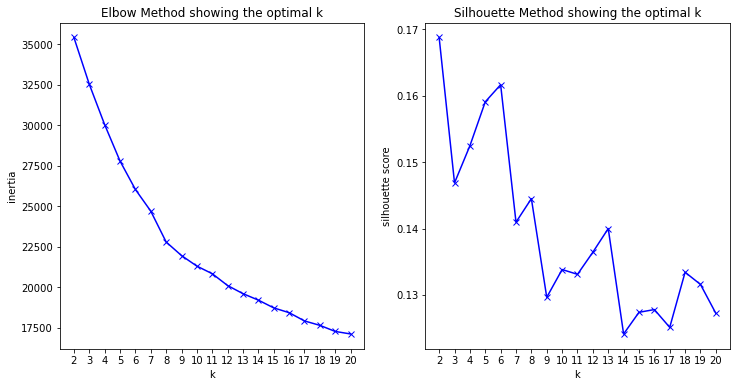

In [15]:
K = range(2, 21)

inertia = []
silhouette = []

for k in K:
    # print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234,
                    verbose=1)
    kmeans.fit(X_scaled_df)
    
    filename = "models/kmeans_" + str(k) + ".pickle" # Path with filename
    with open(filename, "wb") as file:
        pickle.dump(kmeans,file)

    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

As we can see k=7 is the best option.

In [16]:
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as file: 
            return pickle.load(file) 
    except FileNotFoundError: 
        print("File not found!") 

Saving the scaler we used as 'use_scaler' and the best model as a variable 'best_model'.

In [17]:
use_scaler = load("scalers/standard.pickle")
use_scaler

StandardScaler()

In [18]:
best_model_kmeans = load("models/kmeans_7.pickle")
best_model_kmeans

KMeans(n_clusters=7, random_state=1234, verbose=1)

Saving the results of the best model as a separate column in our datadrame.

In [19]:
filepath = 'models/kmeans_7.pickle'

with open(filepath, 'rb') as file:
    kmeans = pickle.load(file)

clusters = kmeans.predict(X_scaled_df)
final_dataset_with_prediction = final_dataset.copy()
final_dataset_with_prediction['kmeans_7'] = kmeans.predict(X_scaled_df)
final_dataset_with_prediction.head()

,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,s_type,kmeans_7
0,anti-hero,taylor swift,0.637,0.643,4.0,-6.571,1.0,0.0519,0.130,0.000002,0.142,0.5330,97.008,audio_features,0V3wPSX9ygBnCm8psDIegu,spotify:track:0V3wPSX9ygBnCm8psDIegu,https://api.spotify.com/v1/tracks/0V3wPSX9ygBn...,https://api.spotify.com/v1/audio-analysis/0V3w...,200690.0,4.0,hot,2
1,lift me up,rihanna,0.247,0.299,9.0,-6.083,1.0,0.0315,0.899,0.000000,0.131,0.1720,177.115,audio_features,35ovElsgyAtQwYPYnZJECg,spotify:track:35ovElsgyAtQwYPYnZJECg,https://api.spotify.com/v1/tracks/35ovElsgyAtQ...,https://api.spotify.com/v1/audio-analysis/35ov...,196520.0,4.0,hot,3
2,bad habit,steve lacy,0.686,0.507,1.0,-7.097,1.0,0.0357,0.626,0.000075,0.383,0.6900,168.955,audio_features,5CM4UuQ9Gnd6K2YyKGPMoK,spotify:track:5CM4UuQ9Gnd6K2YyKGPMoK,https://api.spotify.com/v1/tracks/5CM4UuQ9Gnd6...,https://api.spotify.com/v1/audio-analysis/5CM4...,232115.0,4.0,hot,2
3,as it was,harry styles,0.520,0.731,6.0,-5.338,0.0,0.0557,0.342,0.001010,0.311,0.6620,173.930,audio_features,4LRPiXqCikLlN15c3yImP7,spotify:track:4LRPiXqCikLlN15c3yImP7,https://api.spotify.com/v1/tracks/4LRPiXqCikLl...,https://api.spotify.com/v1/audio-analysis/4LRP...,167303.0,4.0,hot,6
4,lavender haze,taylor swift,0.733,0.436,10.0,-10.489,1.0,0.0800,0.258,0.000573,0.157,0.0976,96.985,audio_features,5jQI2r1RdgtuT8S3iG8zFC,spotify:track:5jQI2r1RdgtuT8S3iG8zFC,https://api.spotify.com/v1/tracks/5jQI2r1Rdgtu...,https://api.spotify.com/v1/audio-analysis/5jQI...,202396.0,4.0,hot,2


<h2>2. Agglomerative clustering (by Guiherme)</h2>

In [20]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
display(X.describe().T)
print()
display(X_scaled_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
danceability,3862.0,0.553194,0.160631,0.099400,0.442000,0.557000,0.666750,0.979
energy,3862.0,0.575971,0.237851,0.022000,0.391000,0.588000,0.770000,0.998
key,3862.0,5.347488,3.564613,0.000000,2.000000,5.000000,9.000000,11.000
loudness,3862.0,-9.529673,4.093479,-33.424000,-12.179250,-8.984500,-6.367000,-0.734
mode,3862.0,0.713102,0.452372,0.000000,0.000000,1.000000,1.000000,1.000
speechiness,3862.0,0.069089,0.074288,0.022600,0.032000,0.040950,0.067875,0.914
acousticness,3862.0,0.330068,0.321780,0.000001,0.031950,0.218000,0.614750,0.995
instrumentalness,3862.0,0.077450,0.209585,0.000000,0.000000,0.000079,0.007488,0.985
liveness,3862.0,0.196391,0.167400,0.018500,0.094525,0.127000,0.244000,0.991
tempo,3862.0,120.167296,29.528068,38.498000,96.491500,118.033500,139.953000,209.034


,count,mean,std,min,25%,50%,75%,max
danceability,3862.0,5.746597e-17,1.000129,-2.825443,-0.692323,0.023699,0.707032,2.651185
energy,3862.0,-1.619626e-16,1.000129,-2.329367,-0.777775,0.050581,0.815865,1.774572
key,3862.0,6.669387e-17,1.000129,-1.500354,-0.939210,-0.097495,1.024791,1.585935
loudness,3862.0,2.878761e-16,1.000129,-5.837924,-0.647352,0.133198,0.772712,2.148982
mode,3862.0,1.083775e-16,1.000129,-1.576566,-1.576566,0.634290,0.634290,0.634290
speechiness,3862.0,-4.174117e-17,1.000129,-0.625872,-0.499321,-0.378828,-0.016340,11.374943
acousticness,3862.0,-1.613302e-16,1.000129,-1.025885,-0.926585,-0.348320,0.884824,2.066684
instrumentalness,3862.0,-1.559975e-16,1.000129,-0.369588,-0.369588,-0.369210,-0.333858,4.330788
liveness,3862.0,4.199989e-17,1.000129,-1.062807,-0.608596,-0.414574,0.284442,4.747393
tempo,3862.0,-1.008170e-16,1.000129,-2.766177,-0.801910,-0.072273,0.670151,3.009957


In [21]:
aglo = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
#aglo.fit(X_scaled_df)
clusters = aglo.fit_predict(X_scaled_df)
clusters

array([3601, 2303, 2405, ...,    3,    1,    0], dtype=int64)

In [22]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

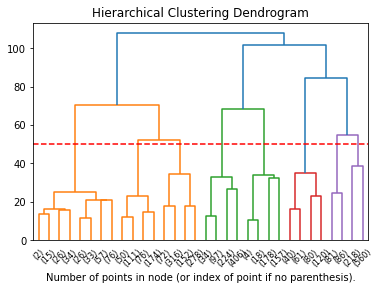

In [23]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(aglo, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=50, color='r', linestyle='--')
plt.show()

In [24]:
K = range(2, 21)
silhouette = []
i=0
for k in K:
    
    print("Training a Agglomeration model with {} neighbours! ".format(k))
    print()
    aglo = AgglomerativeClustering(n_clusters=k)
    aglo.fit_predict(X_scaled_df)
    filename = "models/aglo_" + str(k) + ".pickle" # Path with filename
    with open(filename, "wb") as file:
        pickle.dump(aglo,file)
    silhouette.append(silhouette_score(X_scaled_df, aglo.fit_predict(X_scaled_df)))
    print("Silhouette score turned out to be {}".format(round(silhouette[i], 4)))
    print("------------------------------------------------------")
    i+=1

Training a Agglomeration model with 2 neighbours! 

Silhouette score turned out to be 0.1261
------------------------------------------------------
Training a Agglomeration model with 3 neighbours! 

Silhouette score turned out to be 0.1633
------------------------------------------------------
Training a Agglomeration model with 4 neighbours! 

Silhouette score turned out to be 0.1812
------------------------------------------------------
Training a Agglomeration model with 5 neighbours! 

Silhouette score turned out to be 0.1843
------------------------------------------------------
Training a Agglomeration model with 6 neighbours! 

Silhouette score turned out to be 0.1879
------------------------------------------------------
Training a Agglomeration model with 7 neighbours! 

Silhouette score turned out to be 0.1932
------------------------------------------------------
Training a Agglomeration model with 8 neighbours! 

Silhouette score turned out to be 0.1752
-------------------

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

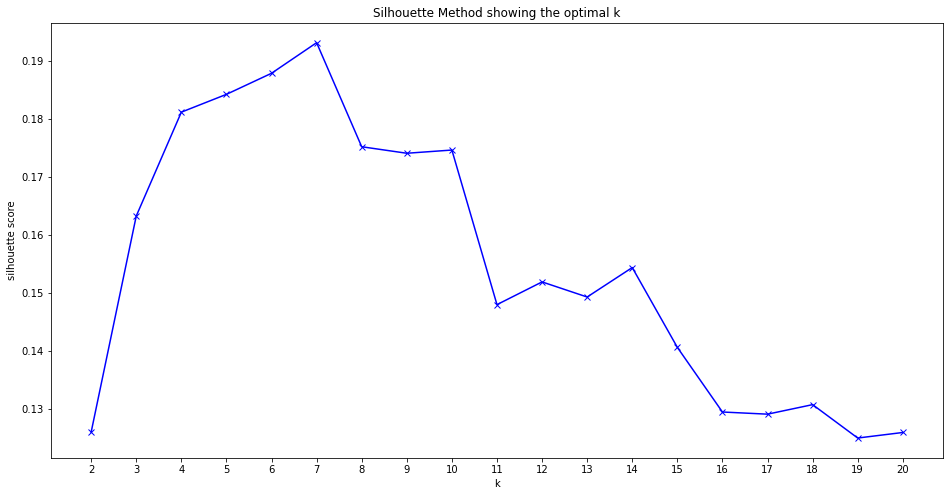

In [25]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

ax.plot(K, silhouette, 'bx-')
ax.set_xlabel('k')
ax.set_ylabel('silhouette score')
ax.set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax.set_title('Silhouette Method showing the optimal k')

In [26]:
L=['ward', 'complete', 'average', 'single']
n_silhouette = []
i=0
for lin in L:
    
    print("Training a Agglomeration model with 7 neighbours and {} linkage!".format(lin))
    print()
    aglo = AgglomerativeClustering(n_clusters=7, linkage=lin)
    aglo.fit_predict(X_scaled_df)
    filename = "models/aglo_7_" + str(lin) + ".pickle" # Path with filename
    with open(filename, "wb") as file:
        pickle.dump(aglo,file)
    n_silhouette.append(silhouette_score(X_scaled_df, aglo.fit_predict(X_scaled_df)))
    print("Silhouette score turned out to be {}".format(n_silhouette[i]))
    print("-----------------------------------------------------")
    i+=1

Training a Agglomeration model with 7 neighbours and ward linkage!

Silhouette score turned out to be 0.19317982999713118
-----------------------------------------------------
Training a Agglomeration model with 7 neighbours and complete linkage!

Silhouette score turned out to be 0.154017433438531
-----------------------------------------------------
Training a Agglomeration model with 7 neighbours and average linkage!

Silhouette score turned out to be 0.3544837299061119
-----------------------------------------------------
Training a Agglomeration model with 7 neighbours and single linkage!

Silhouette score turned out to be 0.35471986824927687
-----------------------------------------------------


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

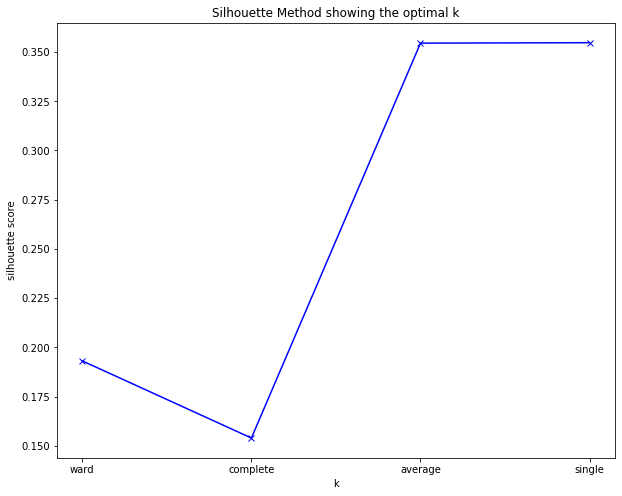

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(L, n_silhouette, 'bx-')
ax.set_xlabel('k')
ax.set_ylabel('silhouette score')
ax.set_title('Silhouette Method showing the optimal k')

In [28]:
def load(filename = "filename.pickle"): 
    try: 
        with open("models/"+filename, "rb") as file: 
            return pickle.load(file) 
    except FileNotFoundError: 
        print("File not found!") 

In [29]:
sin_model = load("aglo_7_single.pickle")
sin_aglo = sin_model.fit_predict(X_scaled_df)
final_dataset_with_prediction['sin_aglo']=sin_aglo

In [30]:
avg_model = load("aglo_7_average.pickle")
avg_aglo = avg_model.fit_predict(X_scaled_df)
final_dataset_with_prediction['avg_aglo']=avg_aglo

In [31]:
ward_model = load("aglo_7_ward.pickle")
ward_aglo = ward_model.fit_predict(X_scaled_df)
final_dataset_with_prediction['ward_aglo']=ward_aglo

In [32]:
cmp_model = load("aglo_7_complete.pickle")
cmp_aglo = cmp_model.fit_predict(X_scaled_df)
final_dataset_with_prediction['cmp_aglo']=cmp_aglo

In [33]:
display(final_dataset_with_prediction.head())

,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,s_type,kmeans_7,sin_aglo,avg_aglo,ward_aglo,cmp_aglo
0,anti-hero,taylor swift,0.637,0.643,4.0,-6.571,1.0,0.0519,0.130,0.000002,0.142,0.5330,97.008,audio_features,0V3wPSX9ygBnCm8psDIegu,spotify:track:0V3wPSX9ygBnCm8psDIegu,https://api.spotify.com/v1/tracks/0V3wPSX9ygBn...,https://api.spotify.com/v1/audio-analysis/0V3w...,200690.0,4.0,hot,2,0,2,0,5
1,lift me up,rihanna,0.247,0.299,9.0,-6.083,1.0,0.0315,0.899,0.000000,0.131,0.1720,177.115,audio_features,35ovElsgyAtQwYPYnZJECg,spotify:track:35ovElsgyAtQwYPYnZJECg,https://api.spotify.com/v1/tracks/35ovElsgyAtQ...,https://api.spotify.com/v1/audio-analysis/35ov...,196520.0,4.0,hot,3,0,2,5,0
2,bad habit,steve lacy,0.686,0.507,1.0,-7.097,1.0,0.0357,0.626,0.000075,0.383,0.6900,168.955,audio_features,5CM4UuQ9Gnd6K2YyKGPMoK,spotify:track:5CM4UuQ9Gnd6K2YyKGPMoK,https://api.spotify.com/v1/tracks/5CM4UuQ9Gnd6...,https://api.spotify.com/v1/audio-analysis/5CM4...,232115.0,4.0,hot,2,0,2,6,0
3,as it was,harry styles,0.520,0.731,6.0,-5.338,0.0,0.0557,0.342,0.001010,0.311,0.6620,173.930,audio_features,4LRPiXqCikLlN15c3yImP7,spotify:track:4LRPiXqCikLlN15c3yImP7,https://api.spotify.com/v1/tracks/4LRPiXqCikLl...,https://api.spotify.com/v1/audio-analysis/4LRP...,167303.0,4.0,hot,6,0,2,2,5
4,lavender haze,taylor swift,0.733,0.436,10.0,-10.489,1.0,0.0800,0.258,0.000573,0.157,0.0976,96.985,audio_features,5jQI2r1RdgtuT8S3iG8zFC,spotify:track:5jQI2r1RdgtuT8S3iG8zFC,https://api.spotify.com/v1/tracks/5jQI2r1Rdgtu...,https://api.spotify.com/v1/audio-analysis/5jQI...,202396.0,4.0,hot,2,0,2,0,5


<h2>3. Gaussian Mixtures (by Rafael)</h2>

<h3>Training method</h3>

<h4>Full covariance matrix:</h4>

In [34]:
# Testing with 1 cluster with an spherical shape per column.

gmm = GaussianMixture(n_components=11, covariance_type='full')

In [35]:
gmm.fit(X_scaled_df)

GaussianMixture(n_components=11)

<h3>Predicting the clusters</h3>

<h4>Gaussian Mixture 11 clusters:</h4>

In [36]:
ygmm_hat = gmm.predict(X_scaled_df)
ygmm_hat

array([0, 5, 3, ..., 4, 0, 5], dtype=int64)

In [37]:
X["GMM11_cluster"] = ygmm_hat

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster
0,0.637,0.643,4.0,-6.571,1.0,0.0519,0.1300,0.000002,0.1420,97.008,4.0,0,0
1,0.247,0.299,9.0,-6.083,1.0,0.0315,0.8990,0.000000,0.1310,177.115,4.0,2,5
2,0.686,0.507,1.0,-7.097,1.0,0.0357,0.6260,0.000075,0.3830,168.955,4.0,3,3
3,0.520,0.731,6.0,-5.338,0.0,0.0557,0.3420,0.001010,0.3110,173.930,4.0,3,1
4,0.733,0.436,10.0,-10.489,1.0,0.0800,0.2580,0.000573,0.1570,96.985,4.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8.0,-15.821,1.0,0.0436,0.1360,0.000019,0.0721,94.566,4.0,0,0
3858,0.576,0.834,9.0,-3.089,0.0,0.0470,0.3450,0.000000,0.1880,78.713,4.0,0,7
3859,0.620,0.282,5.0,-10.533,0.0,0.0464,0.6940,0.000000,0.1190,124.609,3.0,2,4
3860,0.700,0.620,2.0,-9.360,1.0,0.0797,0.0175,0.000003,0.0891,173.998,4.0,0,0


In [38]:
ss_gmm11 = silhouette_score(X_scaled_df, gmm.predict(X_scaled_df))

print(ss_gmm11)

0.17766084474247995


<h4>Gaussian Mixture 6 clusters:</h4>

In [39]:
gmm2 = GaussianMixture(n_components=6, covariance_type='full')

In [40]:
gmm2.fit(X_scaled_df)

GaussianMixture(n_components=6)

In [41]:
ygmm_hat2 = gmm2.predict(X_scaled_df)
ygmm_hat2

array([4, 1, 0, ..., 2, 4, 1], dtype=int64)

In [42]:
X["GMM6_cluster"] = ygmm_hat2

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster
0,0.637,0.643,4.0,-6.571,1.0,0.0519,0.1300,0.000002,0.1420,97.008,4.0,0,0,4
1,0.247,0.299,9.0,-6.083,1.0,0.0315,0.8990,0.000000,0.1310,177.115,4.0,2,5,1
2,0.686,0.507,1.0,-7.097,1.0,0.0357,0.6260,0.000075,0.3830,168.955,4.0,3,3,0
3,0.520,0.731,6.0,-5.338,0.0,0.0557,0.3420,0.001010,0.3110,173.930,4.0,3,1,0
4,0.733,0.436,10.0,-10.489,1.0,0.0800,0.2580,0.000573,0.1570,96.985,4.0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8.0,-15.821,1.0,0.0436,0.1360,0.000019,0.0721,94.566,4.0,0,0,4
3858,0.576,0.834,9.0,-3.089,0.0,0.0470,0.3450,0.000000,0.1880,78.713,4.0,0,7,3
3859,0.620,0.282,5.0,-10.533,0.0,0.0464,0.6940,0.000000,0.1190,124.609,3.0,2,4,2
3860,0.700,0.620,2.0,-9.360,1.0,0.0797,0.0175,0.000003,0.0891,173.998,4.0,0,0,4


In [43]:
ss_gmm6 = silhouette_score(X_scaled_df, gmm2.predict(X_scaled_df))

print(ss_gmm6)

0.14603674920384543


<h4>Gaussian Mixture 3 clusters:</h4>

In [44]:
gmm3 = GaussianMixture(n_components=3, covariance_type='full')

In [45]:
gmm3.fit(X_scaled_df)

GaussianMixture(n_components=3)

In [46]:
ygmm_hat3 = gmm3.predict(X_scaled_df)
ygmm_hat3

array([2, 0, 1, ..., 0, 2, 0], dtype=int64)

In [47]:
X["GMM3_cluster"] = ygmm_hat3

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster,GMM3_cluster
0,0.637,0.643,4.0,-6.571,1.0,0.0519,0.1300,0.000002,0.1420,97.008,4.0,0,0,4,2
1,0.247,0.299,9.0,-6.083,1.0,0.0315,0.8990,0.000000,0.1310,177.115,4.0,2,5,1,0
2,0.686,0.507,1.0,-7.097,1.0,0.0357,0.6260,0.000075,0.3830,168.955,4.0,3,3,0,1
3,0.520,0.731,6.0,-5.338,0.0,0.0557,0.3420,0.001010,0.3110,173.930,4.0,3,1,0,1
4,0.733,0.436,10.0,-10.489,1.0,0.0800,0.2580,0.000573,0.1570,96.985,4.0,0,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8.0,-15.821,1.0,0.0436,0.1360,0.000019,0.0721,94.566,4.0,0,0,4,2
3858,0.576,0.834,9.0,-3.089,0.0,0.0470,0.3450,0.000000,0.1880,78.713,4.0,0,7,3,2
3859,0.620,0.282,5.0,-10.533,0.0,0.0464,0.6940,0.000000,0.1190,124.609,3.0,2,4,2,0
3860,0.700,0.620,2.0,-9.360,1.0,0.0797,0.0175,0.000003,0.0891,173.998,4.0,0,0,4,2


In [48]:
ss_gmm3 = silhouette_score(X_scaled_df, gmm3.predict(X_scaled_df))

print(ss_gmm3)

0.1788667151082821


<h4>Gaussian Mixture 7 clusters:</h4>

In [49]:
gmm4 = GaussianMixture(n_components=7, covariance_type='full')

In [50]:
gmm4.fit(X_scaled_df)

GaussianMixture(n_components=7)

In [51]:
ygmm_hat4 = gmm4.predict(X_scaled_df)
ygmm_hat4

array([2, 1, 0, ..., 1, 2, 1], dtype=int64)

In [52]:
X["GMM7_cluster"] = ygmm_hat4

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster,GMM3_cluster,GMM7_cluster
0,0.637,0.643,4.0,-6.571,1.0,0.0519,0.1300,0.000002,0.1420,97.008,4.0,0,0,4,2,2
1,0.247,0.299,9.0,-6.083,1.0,0.0315,0.8990,0.000000,0.1310,177.115,4.0,2,5,1,0,1
2,0.686,0.507,1.0,-7.097,1.0,0.0357,0.6260,0.000075,0.3830,168.955,4.0,3,3,0,1,0
3,0.520,0.731,6.0,-5.338,0.0,0.0557,0.3420,0.001010,0.3110,173.930,4.0,3,1,0,1,0
4,0.733,0.436,10.0,-10.489,1.0,0.0800,0.2580,0.000573,0.1570,96.985,4.0,0,0,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8.0,-15.821,1.0,0.0436,0.1360,0.000019,0.0721,94.566,4.0,0,0,4,2,2
3858,0.576,0.834,9.0,-3.089,0.0,0.0470,0.3450,0.000000,0.1880,78.713,4.0,0,7,3,2,2
3859,0.620,0.282,5.0,-10.533,0.0,0.0464,0.6940,0.000000,0.1190,124.609,3.0,2,4,2,0,1
3860,0.700,0.620,2.0,-9.360,1.0,0.0797,0.0175,0.000003,0.0891,173.998,4.0,0,0,4,2,2


In [53]:
ss_gmm7 = silhouette_score(X_scaled_df, gmm4.predict(X_scaled_df))

print(ss_gmm7)

0.14094023254418317


<h4>Gaussian Mixture 8 clusters:</h4>

In [54]:
gmm5 = GaussianMixture(n_components=8, covariance_type='full')

In [55]:
gmm5.fit(X_scaled_df)

GaussianMixture(n_components=8)

In [56]:
ygmm_hat5 = gmm5.predict(X_scaled_df)
ygmm_hat5

array([5, 6, 6, ..., 0, 5, 6], dtype=int64)

In [57]:
X["GMM8_cluster"] = ygmm_hat5

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster,GMM3_cluster,GMM7_cluster,GMM8_cluster
0,0.637,0.643,4.0,-6.571,1.0,0.0519,0.1300,0.000002,0.1420,97.008,4.0,0,0,4,2,2,5
1,0.247,0.299,9.0,-6.083,1.0,0.0315,0.8990,0.000000,0.1310,177.115,4.0,2,5,1,0,1,6
2,0.686,0.507,1.0,-7.097,1.0,0.0357,0.6260,0.000075,0.3830,168.955,4.0,3,3,0,1,0,6
3,0.520,0.731,6.0,-5.338,0.0,0.0557,0.3420,0.001010,0.3110,173.930,4.0,3,1,0,1,0,2
4,0.733,0.436,10.0,-10.489,1.0,0.0800,0.2580,0.000573,0.1570,96.985,4.0,0,0,4,2,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8.0,-15.821,1.0,0.0436,0.1360,0.000019,0.0721,94.566,4.0,0,0,4,2,2,5
3858,0.576,0.834,9.0,-3.089,0.0,0.0470,0.3450,0.000000,0.1880,78.713,4.0,0,7,3,2,2,4
3859,0.620,0.282,5.0,-10.533,0.0,0.0464,0.6940,0.000000,0.1190,124.609,3.0,2,4,2,0,1,0
3860,0.700,0.620,2.0,-9.360,1.0,0.0797,0.0175,0.000003,0.0891,173.998,4.0,0,0,4,2,2,5


In [58]:
ss_gmm8 = silhouette_score(X_scaled_df, gmm5.predict(X_scaled_df))

print(ss_gmm8)

0.11258695228960046


 <h3>Comparing silhouette scores:</h3>


In [59]:
print(f'The Silhouette score for the Gaussian Mixture with 11 clusters is: {(round(ss_gmm11,4))}')
print(f'The Silhouette score for the Gaussian Mixture with 8 clusters is: {(round(ss_gmm8,4))}')
print(f'The Silhouette score for the Gaussian Mixture with 7 clusters is: {(round(ss_gmm7,4))}')
print(f'The Silhouette score for the Gaussian Mixture with 6 clusters is: {(round(ss_gmm6,4))}')
print(f'The Silhouette score for the Gaussian Mixture with 3 clusters is: {(round(ss_gmm3,4))}')
print('')
print('The optimal number of clusters is 7.')

The Silhouette score for the Gaussian Mixture with 11 clusters is: 0.1777
The Silhouette score for the Gaussian Mixture with 8 clusters is: 0.1126
The Silhouette score for the Gaussian Mixture with 7 clusters is: 0.1409
The Silhouette score for the Gaussian Mixture with 6 clusters is: 0.146
The Silhouette score for the Gaussian Mixture with 3 clusters is: 0.1789

The optimal number of clusters is 7.


<h2>Gaussian Mixtures:</h2>

<h3>Training method:</h3>

<h3>Tied covariance matrix:</h3>

In [60]:
gmm_tied = GaussianMixture(n_components=7, covariance_type='tied')

In [61]:
gmm_tied.fit(X_scaled_df)

GaussianMixture(covariance_type='tied', n_components=7)

In [62]:
ygmm_hat_tied = gmm_tied.predict(X_scaled_df)
ygmm_hat_tied

array([3, 1, 4, ..., 6, 3, 1], dtype=int64)

In [63]:
X["GMM7_tied_cluster"] = ygmm_hat_tied

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster,GMM3_cluster,GMM7_cluster,GMM8_cluster,GMM7_tied_cluster
0,0.637,0.643,4.0,-6.571,1.0,0.0519,0.1300,0.000002,0.1420,97.008,4.0,0,0,4,2,2,5,3
1,0.247,0.299,9.0,-6.083,1.0,0.0315,0.8990,0.000000,0.1310,177.115,4.0,2,5,1,0,1,6,1
2,0.686,0.507,1.0,-7.097,1.0,0.0357,0.6260,0.000075,0.3830,168.955,4.0,3,3,0,1,0,6,4
3,0.520,0.731,6.0,-5.338,0.0,0.0557,0.3420,0.001010,0.3110,173.930,4.0,3,1,0,1,0,2,4
4,0.733,0.436,10.0,-10.489,1.0,0.0800,0.2580,0.000573,0.1570,96.985,4.0,0,0,4,2,2,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8.0,-15.821,1.0,0.0436,0.1360,0.000019,0.0721,94.566,4.0,0,0,4,2,2,5,3
3858,0.576,0.834,9.0,-3.089,0.0,0.0470,0.3450,0.000000,0.1880,78.713,4.0,0,7,3,2,2,4,0
3859,0.620,0.282,5.0,-10.533,0.0,0.0464,0.6940,0.000000,0.1190,124.609,3.0,2,4,2,0,1,0,6
3860,0.700,0.620,2.0,-9.360,1.0,0.0797,0.0175,0.000003,0.0891,173.998,4.0,0,0,4,2,2,5,3


In [64]:
ss_gmm_tied = silhouette_score(X_scaled_df, gmm_tied.predict(X_scaled_df))

print(ss_gmm_tied)

0.1520707319616015


<h2>Gaussian Mixtures:</h2>

<h3>Training method:</h3>

<h3>Diagonal covariance matrix:</h3>

<h3>Gaussian Mixture (diagonal) - 7 clusters:</h3>


In [65]:
gmm_d = GaussianMixture(n_components=7, covariance_type='diag')

In [66]:
gmm_d.fit(X_scaled_df)

GaussianMixture(covariance_type='diag', n_components=7)

In [67]:
ygmm_hat_d = gmm_d.predict(X_scaled_df)
ygmm_hat_d

array([1, 6, 0, ..., 2, 1, 6], dtype=int64)

In [68]:
X["GMM7_diag_cluster"] = ygmm_hat_d

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster,GMM3_cluster,GMM7_cluster,GMM8_cluster,GMM7_tied_cluster,GMM7_diag_cluster
0,0.637,0.643,4.0,-6.571,1.0,0.0519,0.1300,0.000002,0.1420,97.008,4.0,0,0,4,2,2,5,3,1
1,0.247,0.299,9.0,-6.083,1.0,0.0315,0.8990,0.000000,0.1310,177.115,4.0,2,5,1,0,1,6,1,6
2,0.686,0.507,1.0,-7.097,1.0,0.0357,0.6260,0.000075,0.3830,168.955,4.0,3,3,0,1,0,6,4,0
3,0.520,0.731,6.0,-5.338,0.0,0.0557,0.3420,0.001010,0.3110,173.930,4.0,3,1,0,1,0,2,4,0
4,0.733,0.436,10.0,-10.489,1.0,0.0800,0.2580,0.000573,0.1570,96.985,4.0,0,0,4,2,2,5,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8.0,-15.821,1.0,0.0436,0.1360,0.000019,0.0721,94.566,4.0,0,0,4,2,2,5,3,1
3858,0.576,0.834,9.0,-3.089,0.0,0.0470,0.3450,0.000000,0.1880,78.713,4.0,0,7,3,2,2,4,0,1
3859,0.620,0.282,5.0,-10.533,0.0,0.0464,0.6940,0.000000,0.1190,124.609,3.0,2,4,2,0,1,0,6,2
3860,0.700,0.620,2.0,-9.360,1.0,0.0797,0.0175,0.000003,0.0891,173.998,4.0,0,0,4,2,2,5,3,1


In [69]:
ss_gmm_d = silhouette_score(X_scaled_df, gmm_d.predict(X_scaled_df))

print(ss_gmm_d)

0.15857659966758808


<h2>Gaussian Mixtures:</h2>

<h3>Training method:</h3>

<h3>Diagonal covariance matrix:</h3>

<h3>Gaussian Mixture (spherical) - 7 clusters:</h3>

In [70]:
gmm_s = GaussianMixture(n_components=7, covariance_type='spherical')

In [71]:
gmm_s.fit(X_scaled_df)

GaussianMixture(covariance_type='spherical', n_components=7)

In [72]:
ygmm_hat_s = gmm_s.predict(X_scaled_df)
ygmm_hat_s

array([1, 3, 5, ..., 6, 1, 3], dtype=int64)

In [73]:
X["GMM7_spherical_cluster"] = ygmm_hat_s

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster,GMM3_cluster,GMM7_cluster,GMM8_cluster,GMM7_tied_cluster,GMM7_diag_cluster,GMM7_spherical_cluster
0,0.637,0.643,4.0,-6.571,1.0,0.0519,0.1300,0.000002,0.1420,97.008,4.0,0,0,4,2,2,5,3,1,1
1,0.247,0.299,9.0,-6.083,1.0,0.0315,0.8990,0.000000,0.1310,177.115,4.0,2,5,1,0,1,6,1,6,3
2,0.686,0.507,1.0,-7.097,1.0,0.0357,0.6260,0.000075,0.3830,168.955,4.0,3,3,0,1,0,6,4,0,5
3,0.520,0.731,6.0,-5.338,0.0,0.0557,0.3420,0.001010,0.3110,173.930,4.0,3,1,0,1,0,2,4,0,5
4,0.733,0.436,10.0,-10.489,1.0,0.0800,0.2580,0.000573,0.1570,96.985,4.0,0,0,4,2,2,5,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8.0,-15.821,1.0,0.0436,0.1360,0.000019,0.0721,94.566,4.0,0,0,4,2,2,5,3,1,1
3858,0.576,0.834,9.0,-3.089,0.0,0.0470,0.3450,0.000000,0.1880,78.713,4.0,0,7,3,2,2,4,0,1,2
3859,0.620,0.282,5.0,-10.533,0.0,0.0464,0.6940,0.000000,0.1190,124.609,3.0,2,4,2,0,1,0,6,2,6
3860,0.700,0.620,2.0,-9.360,1.0,0.0797,0.0175,0.000003,0.0891,173.998,4.0,0,0,4,2,2,5,3,1,1


In [74]:
ss_gmm_s = silhouette_score(X_scaled_df, gmm_s.predict(X_scaled_df))

print(ss_gmm_s)

0.17432198552523442


In [75]:
gmm_s8 = GaussianMixture(n_components=8, covariance_type='spherical')

In [76]:
gmm_s8.fit(X_scaled_df)

GaussianMixture(covariance_type='spherical', n_components=8)

In [77]:
ygmm_hat_s8 = gmm_s8.predict(X_scaled_df)
ygmm_hat_s8

array([5, 2, 2, ..., 2, 5, 2], dtype=int64)

In [78]:
X["GMM8_spherical_cluster"] = ygmm_hat_s

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster,GMM3_cluster,GMM7_cluster,GMM8_cluster,GMM7_tied_cluster,GMM7_diag_cluster,GMM7_spherical_cluster,GMM8_spherical_cluster
0,0.637,0.643,4.0,-6.571,1.0,0.0519,0.1300,0.000002,0.1420,97.008,4.0,0,0,4,2,2,5,3,1,1,1
1,0.247,0.299,9.0,-6.083,1.0,0.0315,0.8990,0.000000,0.1310,177.115,4.0,2,5,1,0,1,6,1,6,3,3
2,0.686,0.507,1.0,-7.097,1.0,0.0357,0.6260,0.000075,0.3830,168.955,4.0,3,3,0,1,0,6,4,0,5,5
3,0.520,0.731,6.0,-5.338,0.0,0.0557,0.3420,0.001010,0.3110,173.930,4.0,3,1,0,1,0,2,4,0,5,5
4,0.733,0.436,10.0,-10.489,1.0,0.0800,0.2580,0.000573,0.1570,96.985,4.0,0,0,4,2,2,5,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8.0,-15.821,1.0,0.0436,0.1360,0.000019,0.0721,94.566,4.0,0,0,4,2,2,5,3,1,1,1
3858,0.576,0.834,9.0,-3.089,0.0,0.0470,0.3450,0.000000,0.1880,78.713,4.0,0,7,3,2,2,4,0,1,2,2
3859,0.620,0.282,5.0,-10.533,0.0,0.0464,0.6940,0.000000,0.1190,124.609,3.0,2,4,2,0,1,0,6,2,6,6
3860,0.700,0.620,2.0,-9.360,1.0,0.0797,0.0175,0.000003,0.0891,173.998,4.0,0,0,4,2,2,5,3,1,1,1


In [79]:
ss_gmm_8 = silhouette_score(X_scaled_df, gmm_s8.predict(X_scaled_df))

print(ss_gmm_8)

0.16219340439232605


<h2>Conclusions: </h2>

Between all the models the one with the highest silhouette score is the spherical Gaussian Mixture with 7 Clusters.

In [80]:
print(f'The Silhouette score for the full Gaussian Mixture with 7 clusters is: {(round(ss_gmm7,4))}')
print(f'The Silhouette score for the tied Gaussian Mixture with 7 clusters is: {(round(ss_gmm_tied,4))}')
print(f'The Silhouette score for the diagonal Gaussian Mixture with 7 clusters is: {(round(ss_gmm_d,4))}')
print(f'The Silhouette score for the spherical Gaussian Mixture with 7 clusters is: {(round(ss_gmm_s,4))}')
print('')
print('The optimal model for the Gaussian Mixture is spherical with 7 clusters.')

The Silhouette score for the full Gaussian Mixture with 7 clusters is: 0.1409
The Silhouette score for the tied Gaussian Mixture with 7 clusters is: 0.1521
The Silhouette score for the diagonal Gaussian Mixture with 7 clusters is: 0.1586
The Silhouette score for the spherical Gaussian Mixture with 7 clusters is: 0.1743

The optimal model for the Gaussian Mixture is spherical with 7 clusters.


In [81]:
X['GMM7_spherical_cluster'].value_counts()

5    907
1    814
3    795
2    421
6    339
4    297
0    289
Name: GMM7_spherical_cluster, dtype: int64

In [82]:
X["GMM7_spherical_cluster"] = ygmm_hat_s

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster,GMM3_cluster,GMM7_cluster,GMM8_cluster,GMM7_tied_cluster,GMM7_diag_cluster,GMM7_spherical_cluster,GMM8_spherical_cluster
0,0.637,0.643,4.0,-6.571,1.0,0.0519,0.1300,0.000002,0.1420,97.008,4.0,0,0,4,2,2,5,3,1,1,1
1,0.247,0.299,9.0,-6.083,1.0,0.0315,0.8990,0.000000,0.1310,177.115,4.0,2,5,1,0,1,6,1,6,3,3
2,0.686,0.507,1.0,-7.097,1.0,0.0357,0.6260,0.000075,0.3830,168.955,4.0,3,3,0,1,0,6,4,0,5,5
3,0.520,0.731,6.0,-5.338,0.0,0.0557,0.3420,0.001010,0.3110,173.930,4.0,3,1,0,1,0,2,4,0,5,5
4,0.733,0.436,10.0,-10.489,1.0,0.0800,0.2580,0.000573,0.1570,96.985,4.0,0,0,4,2,2,5,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8.0,-15.821,1.0,0.0436,0.1360,0.000019,0.0721,94.566,4.0,0,0,4,2,2,5,3,1,1,1
3858,0.576,0.834,9.0,-3.089,0.0,0.0470,0.3450,0.000000,0.1880,78.713,4.0,0,7,3,2,2,4,0,1,2,2
3859,0.620,0.282,5.0,-10.533,0.0,0.0464,0.6940,0.000000,0.1190,124.609,3.0,2,4,2,0,1,0,6,2,6,6
3860,0.700,0.620,2.0,-9.360,1.0,0.0797,0.0175,0.000003,0.0891,173.998,4.0,0,0,4,2,2,5,3,1,1,1


In [83]:
final_dataset_with_prediction['GMM7'] = X["GMM7_spherical_cluster"]
final_dataset_with_prediction.head()

,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,s_type,kmeans_7,sin_aglo,avg_aglo,ward_aglo,cmp_aglo,GMM7
0,anti-hero,taylor swift,0.637,0.643,4.0,-6.571,1.0,0.0519,0.130,0.000002,0.142,0.5330,97.008,audio_features,0V3wPSX9ygBnCm8psDIegu,spotify:track:0V3wPSX9ygBnCm8psDIegu,https://api.spotify.com/v1/tracks/0V3wPSX9ygBn...,https://api.spotify.com/v1/audio-analysis/0V3w...,200690.0,4.0,hot,2,0,2,0,5,1
1,lift me up,rihanna,0.247,0.299,9.0,-6.083,1.0,0.0315,0.899,0.000000,0.131,0.1720,177.115,audio_features,35ovElsgyAtQwYPYnZJECg,spotify:track:35ovElsgyAtQwYPYnZJECg,https://api.spotify.com/v1/tracks/35ovElsgyAtQ...,https://api.spotify.com/v1/audio-analysis/35ov...,196520.0,4.0,hot,3,0,2,5,0,3
2,bad habit,steve lacy,0.686,0.507,1.0,-7.097,1.0,0.0357,0.626,0.000075,0.383,0.6900,168.955,audio_features,5CM4UuQ9Gnd6K2YyKGPMoK,spotify:track:5CM4UuQ9Gnd6K2YyKGPMoK,https://api.spotify.com/v1/tracks/5CM4UuQ9Gnd6...,https://api.spotify.com/v1/audio-analysis/5CM4...,232115.0,4.0,hot,2,0,2,6,0,5
3,as it was,harry styles,0.520,0.731,6.0,-5.338,0.0,0.0557,0.342,0.001010,0.311,0.6620,173.930,audio_features,4LRPiXqCikLlN15c3yImP7,spotify:track:4LRPiXqCikLlN15c3yImP7,https://api.spotify.com/v1/tracks/4LRPiXqCikLl...,https://api.spotify.com/v1/audio-analysis/4LRP...,167303.0,4.0,hot,6,0,2,2,5,5
4,lavender haze,taylor swift,0.733,0.436,10.0,-10.489,1.0,0.0800,0.258,0.000573,0.157,0.0976,96.985,audio_features,5jQI2r1RdgtuT8S3iG8zFC,spotify:track:5jQI2r1RdgtuT8S3iG8zFC,https://api.spotify.com/v1/tracks/5jQI2r1Rdgtu...,https://api.spotify.com/v1/audio-analysis/5jQI...,202396.0,4.0,hot,2,0,2,0,5,1


<h2>5. Which model to choose?</h2>

We listened to a couple of songs from our song recommender and decided to choose **[X]** clustering model.

We can check out silhouette_score for each model and choose the highest?

In [84]:
kmeans = KMeans(n_clusters=5, random_state=12345)
kmeans.fit(X_scaled_df)


clusters = kmeans.predict(X_scaled_df) #clusters
pd.Series(clusters).value_counts().sort_index() # Number of songs in each cluster

0     282
1     965
2    1071
3    1260
4     284
dtype: int64

In [85]:
# Kmeans k=7

silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df))


0.205575384531997

In [86]:
# gmm_s 

silhouette_score(X_scaled_df, gmm_s.predict(X_scaled_df))


0.17432198552523442

In [87]:
# cmp_aglo

silhouette_score(X_scaled_df, cmp_model.fit_predict(X_scaled_df))

0.154017433438531

In [88]:
final_dataset_with_prediction.columns

Index(['track_name', 'artist_name', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature', 's_type', 'kmeans_7',
       'sin_aglo', 'avg_aglo', 'ward_aglo', 'cmp_aglo', 'GMM7'],
      dtype='object')

In [89]:
final_dataset_with_prediction = final_dataset_with_prediction.drop(['sin_aglo','avg_aglo', 'ward_aglo', 'cmp_aglo', 'GMM7'], axis = 1)
final_dataset_with_prediction.head()

,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,s_type,kmeans_7
0,anti-hero,taylor swift,0.637,0.643,4.0,-6.571,1.0,0.0519,0.130,0.000002,0.142,0.5330,97.008,audio_features,0V3wPSX9ygBnCm8psDIegu,spotify:track:0V3wPSX9ygBnCm8psDIegu,https://api.spotify.com/v1/tracks/0V3wPSX9ygBn...,https://api.spotify.com/v1/audio-analysis/0V3w...,200690.0,4.0,hot,2
1,lift me up,rihanna,0.247,0.299,9.0,-6.083,1.0,0.0315,0.899,0.000000,0.131,0.1720,177.115,audio_features,35ovElsgyAtQwYPYnZJECg,spotify:track:35ovElsgyAtQwYPYnZJECg,https://api.spotify.com/v1/tracks/35ovElsgyAtQ...,https://api.spotify.com/v1/audio-analysis/35ov...,196520.0,4.0,hot,3
2,bad habit,steve lacy,0.686,0.507,1.0,-7.097,1.0,0.0357,0.626,0.000075,0.383,0.6900,168.955,audio_features,5CM4UuQ9Gnd6K2YyKGPMoK,spotify:track:5CM4UuQ9Gnd6K2YyKGPMoK,https://api.spotify.com/v1/tracks/5CM4UuQ9Gnd6...,https://api.spotify.com/v1/audio-analysis/5CM4...,232115.0,4.0,hot,2
3,as it was,harry styles,0.520,0.731,6.0,-5.338,0.0,0.0557,0.342,0.001010,0.311,0.6620,173.930,audio_features,4LRPiXqCikLlN15c3yImP7,spotify:track:4LRPiXqCikLlN15c3yImP7,https://api.spotify.com/v1/tracks/4LRPiXqCikLl...,https://api.spotify.com/v1/audio-analysis/4LRP...,167303.0,4.0,hot,6
4,lavender haze,taylor swift,0.733,0.436,10.0,-10.489,1.0,0.0800,0.258,0.000573,0.157,0.0976,96.985,audio_features,5jQI2r1RdgtuT8S3iG8zFC,spotify:track:5jQI2r1RdgtuT8S3iG8zFC,https://api.spotify.com/v1/tracks/5jQI2r1Rdgtu...,https://api.spotify.com/v1/audio-analysis/5jQI...,202396.0,4.0,hot,2


In [90]:
final_dataset_with_prediction.to_csv('final_dataset_with_prediction.csv')